In [58]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models from sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb

# Model selection and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [59]:
#Importing dataset 
df = pd.read_csv("/Users/neeraj/Documents/Portfolio_project/Airbnb-Price-Predictor/data/processed/1.Listing_details_1.csv")
df = df[df['price'].notna()]

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3329 entries, 0 to 3456
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3329 non-null   float64
 1   listing_url                                   3329 non-null   object 
 2   scrape_id                                     3329 non-null   int64  
 3   last_scraped                                  3329 non-null   object 
 4   source                                        3329 non-null   object 
 5   name                                          3329 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         2164 non-null   object 
 8   picture_url                                   3329 non-null   object 
 9   host_id                                       3329 non-null   int64 

Remove the irrelevant columns used for scraping and retain only the relevant ones in the dataset. This will help avoid unnecessary processing.

In [61]:

bnb_listing = df.drop(["listing_url","scrape_id","last_scraped","last_scraped","source","description","picture_url","host_url","host_thumbnail_url","host_picture_url","longitude","latitude","amenities","calendar_last_scraped","bathrooms","bedrooms","calendar_updated",'license','host_about'], axis=1)

Grouping columns into relevant groups to make it easier to process the data.

In [62]:
property_unique = ['id','name','neighbourhood_overview']
neighbourhood = ['neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']
host = ["host_id","host_name","host_since","host_location","host_about","host_response_time","host_response_rate","host_acceptance_rate","host_is_superhost","host_neighbourhood","host_listings_count","host_total_listings_count","host_verifications","host_has_profile_pic","host_identity_verified"]
property_details = ["property_type","room_type","accommodates","bathrooms_text","beds"]
price = ["price"]
future_bookings = ['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90','availability_365']
reviews = ["number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d","first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"]
others = ["instant_bookable","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"]

Trying to understand the importance of each variable, including unique and null values, as well as their relationships with other important variables

In [63]:
#Checking if all the listings are unique or not
unique_property_count = bnb_listing['id'].nunique()
print("Number of unique listings based on the 'id' column:", unique_property_count)

Number of unique listings based on the 'id' column: 3329


In [64]:
unique_host_count = bnb_listing['host_id'].nunique()
print("Number of unique host based on the 'host_id' column:", unique_host_count)

Number of unique host based on the 'host_id' column: 873


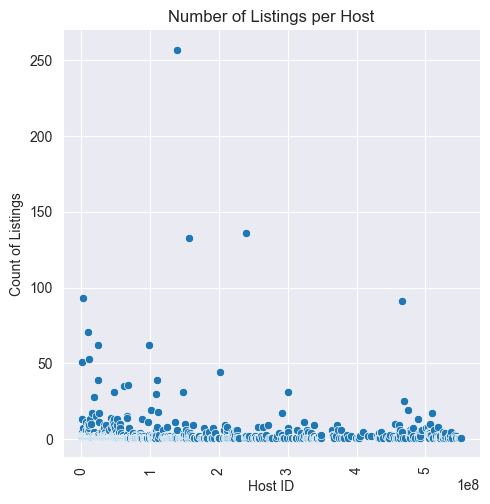

In [65]:
# Assuming total_listing is a Series with host_id as index and count as values
total_listing = bnb_listing.groupby('host_id')['id'].count()

sns.relplot(x=total_listing.index, y=total_listing.values, kind = 'scatter')
plt.xlabel('Host ID')
plt.ylabel('Count of Listings')
plt.title('Number of Listings per Host')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

Understanding More About the Host -  People from outside Singapore are also operating Airbnb listings in Singapore, with the highest numbers coming from India, Indonesia, and France.

In [66]:
print(bnb_listing['host_location'].unique())
by_country = bnb_listing.groupby('host_location')['id'].count()
print(by_country.sort_values(ascending=False))

['Singapore' nan 'Barcelona, Spain' 'Hong Kong' 'Japan' 'Berlin, Germany'
 'Brisbane, Australia' 'Philippine, Netherlands' 'Munich, Germany'
 'Barbastro, Spain' 'Thunder Bay, Canada' 'Kowloon, Hong Kong' 'China'
 'Forrest, Australia' 'Ipswich, United Kingdom' 'Jakarta, Indonesia'
 'Australia' 'Amsterdam, Netherlands' 'Ulsan, South Korea'
 'Agadir, Morocco' 'Uttar Pradesh, India' 'New York, NY' 'Malaysia'
 'Shanghai, China' 'Lower Broadheath, United Kingdom' 'Seattle, WA'
 'Belgium' 'Las Piñas, Philippines' 'Bangkok, Thailand' 'Paris, France'
 'Camperdown, Australia' 'Vancouver, Canada' 'Melbourne, Australia'
 'Seoul, South Korea' 'India' 'Phuket, Thailand' 'Khlong Nueng, Thailand'
 'Copenhagen, Denmark' 'United States' 'Singapore, South Africa'
 'Los Angeles, CA']
host_location
Singapore                           1784
Uttar Pradesh, India                 136
Paris, France                         31
Jakarta, Indonesia                    30
Amsterdam, Netherlands                13
Barbas

Quicker host response times correlate with higher guest ratings, with listings responding within an hour averaging 4.59 compared to 4.17 for those taking a few days or more. This indicates that timely communication may significantly enhance guest satisfaction and overall ratings. 

Potential next stesp -  Conducting a statistical analysis (e.g., ANOVA) to see if the differences in ratings between groups are statistically significant.

In [67]:
Avg_rating_host_response = bnb_listing[bnb_listing["number_of_reviews"] > 0].groupby('host_response_time')['review_scores_rating'].agg(['mean', 'count'])

print(Avg_rating_host_response)

                        mean  count
host_response_time                 
a few days or more  4.172958     71
within a day        4.561836    207
within a few hours  4.531625    363
within an hour      4.594905    789


[nan 'within an hour' 'within a day' 'within a few hours'
 'a few days or more']


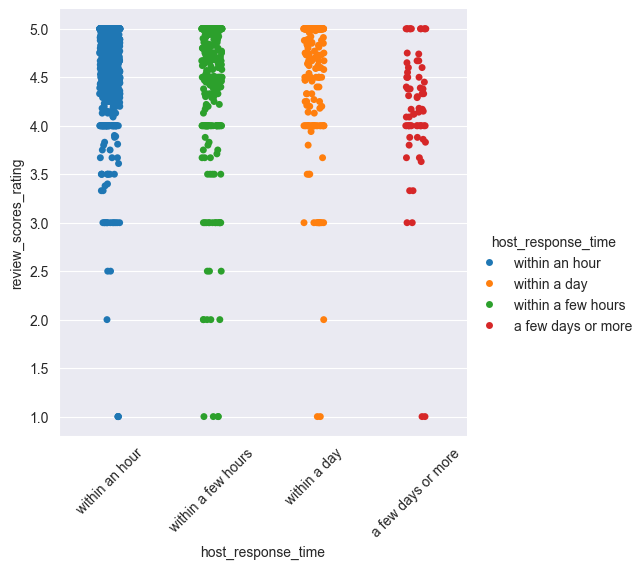

In [68]:
print(bnb_listing['host_response_time'].unique()) #Need to do hot encoding. This can impact rating, let's try to see correlation between rating and reponse time
Category_order = [ 'within an hour','within a few hours','within a day','a few days or more']
sns.catplot(x='host_response_time',y= 'review_scores_rating',data = bnb_listing,hue = 'host_response_time',order = Category_order)
plt.xticks(rotation = 45)
plt.show()


Objective - To understand the impact of reviews on property prices and analyze the distribution of prices across different rating levels.

1. Findings
a) Distribution of Ratings: A significant number of properties are rated above 4 stars, indicating a predominantly positive reception from customers.
b) Correlation Between Price and Rating: Analysis shows that properties at various price points exhibit differing review ratings. Notably, most properties with higher ratings are found at lower price points.
c) Quadrant Analysis: The majority of properties are located in the top-left quadrant of the price-rating graph. This indicates that many properties offer high ratings while maintaining relatively low prices, suggesting a favorable value proposition where customers perceive good quality for their expenditure.

2. Implications
Properties that sustain high ratings while keeping prices competitive are likely to attract more customers, highlighting the importance of quality in enhancing reviews.
This concentration suggests a market trend in which consumers prioritize value, indicating that lowering prices could lead to improved ratings and increased demand.

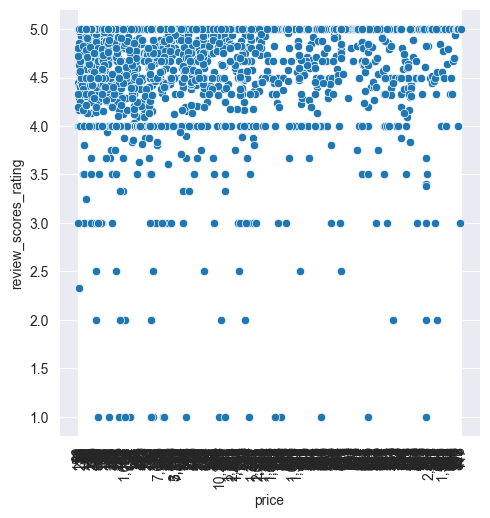

In [69]:
sns.relplot( 
         x = bnb_listing[bnb_listing["number_of_reviews"] > 0]['price'],
         y= bnb_listing[bnb_listing["number_of_reviews"] > 0]['review_scores_rating'], 
         kind = 'scatter'
)
plt.xticks(rotation = 90)
plt.show()


1. Ignoring the reviews content and description for now, we can run NLP to identify specific factors that might influence the correlation between price and the content of the listings. 
2. Additionally, we need to bucketize prices to gain better clarity, as ratings are not directly related to price, as evidenced by the data points above."

In [70]:
# Convert 'price' column to numeric after removing non-numeric characters
bnb_listing['price'] = pd.to_numeric(bnb_listing['price'].str.replace('[^0-9.]', '', regex=True))

# Converting price column to float
for lab, row in bnb_listing.iterrows():
    bnb_listing.at[lab, 'price'] = float(row['price'])

Analysis Overview: We will conduct an in-depth analysis of property features and their corresponding impacts on pricing. The final modeling will focus on determining the appropriate listing price based on various property attributes. Additionally, we will evaluate the following scenarios:

1. Optimal Pricing for Property Attributes: Determine the ideal listing price based on specific property features (e.g., amenities, location, size) to enhance competitiveness and attractiveness.
2. Impact of Property Ratings on Pricing: Analyze how improving property ratings can justify higher listing prices. This includes modeling how changes in ratings can influence potential revenue.
3. Identifying Overcharging: Investigate cases where hosts may be overcharging for their properties, assessing how this could negatively affect occupancy rates. This analysis can help suggest more competitive pricing strategies.
4. Identifying Undercharging: Conversely, analyze properties that are underpriced relative to their features and ratings, providing recommendations for optimal listing prices that align with market expectations.



1. Understanding the various properties type. Top 3 property type are a) Private room in rental unit b) Entire rental unit c) Entire servied apartment

                         property_type  Number of properties
25         Private room in rental unit                   684
9                   Entire rental unit                   593
10           Entire serviced apartment                   582
35                       Room in hotel                   205
3                         Entire condo                   199
19               Private room in condo                   195
22                Private room in home                   167
33              Room in boutique hotel                   119
27  Private room in serviced apartment                    67
29           Private room in townhouse                    50
31                  Room in aparthotel                    50
34                      Room in hostel                    44
45               Shared room in hostel                    42
6                          Entire home                    41
17            Private room in bungalow                    31
47          Shared room 

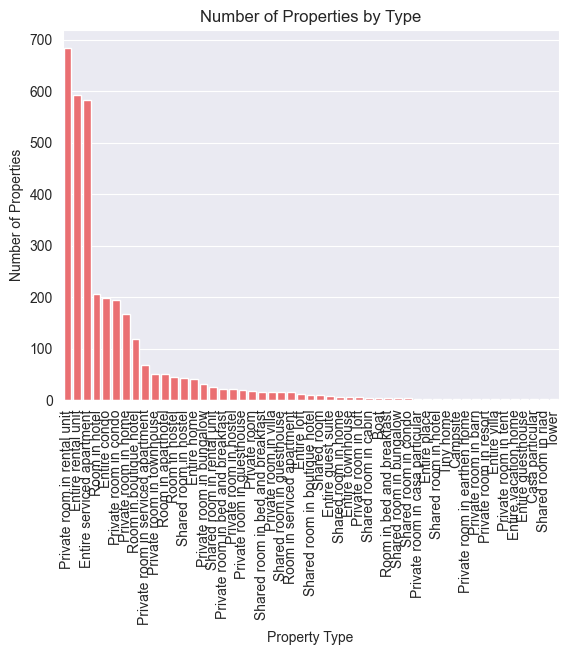

In [71]:
unique_property_types = bnb_listing['property_type'].unique()

# Group by property_type and count occurrences
total_property = bnb_listing.groupby('property_type')['property_type'].count().reset_index(name='Number of properties')
print(total_property.sort_values(by='Number of properties', ascending=False))


sns.barplot(x='property_type', y='Number of properties', data=total_property.sort_values(by='Number of properties', ascending=False),color='#FF5A5F')

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Number of Properties by Type')
plt.xlabel('Property Type')
plt.ylabel('Number of Properties')
plt.show()

Airbnb type
1. Most Listed: Private rooms and entire apartments dominate the listings, reflecting a trend towards offering more private and self-contained accommodations.
2. Moderate Listings: Shared rooms follow, catering to budget-conscious travelers seeking cost-effective options.
3. Least Listed: Hotel rooms are less common, potentially due to misclassification or their close similarity to BNB-style setups.

         room_type  Property_count
0  Entire home/apt            1499
1       Hotel room             107
2     Private room            1586
3      Shared room             137


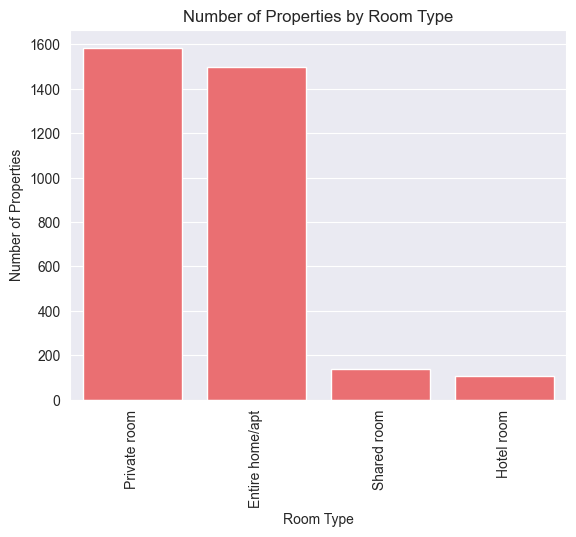

In [72]:
# Get unique room types
unique_room_types = bnb_listing['room_type'].unique()

# Group by room_type and count occurrences
room_type_summary = bnb_listing.groupby('room_type').size().reset_index(name='Property_count')

# Print the room type summary
print(room_type_summary)

# Create a bar graph for the same with Airbnb pink color
sns.barplot(x='room_type', y='Property_count', 
            data=room_type_summary.sort_values(by='Property_count', ascending=False), 
            color='#FF5A5F')

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Number of Properties by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Properties')
plt.show()

Accomodation vs. Price:
1. Pricing Trends: The data shows that larger properties with more accommodations command higher listing prices.
2. Threshold Effect: However, beyond a certain number of accommodations (8 to 10), there is a price decline, likely due to the inclusion of more budget-friendly options like hostels.

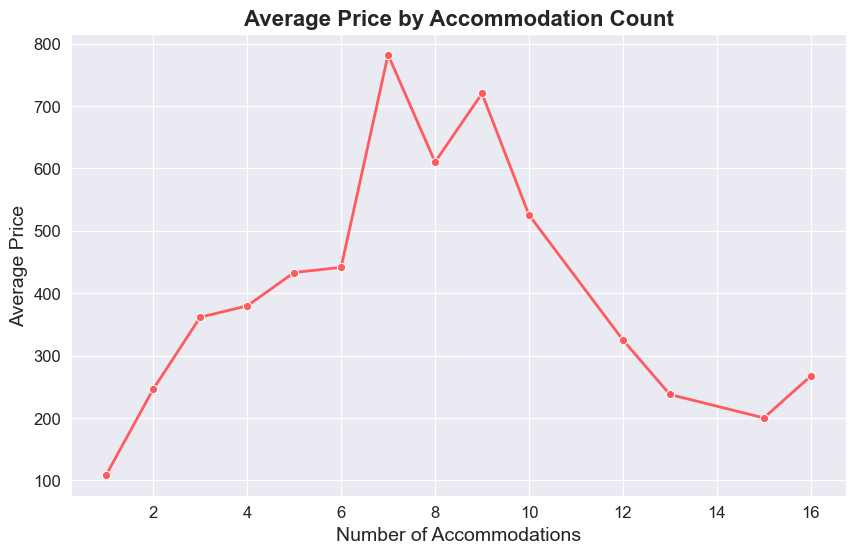

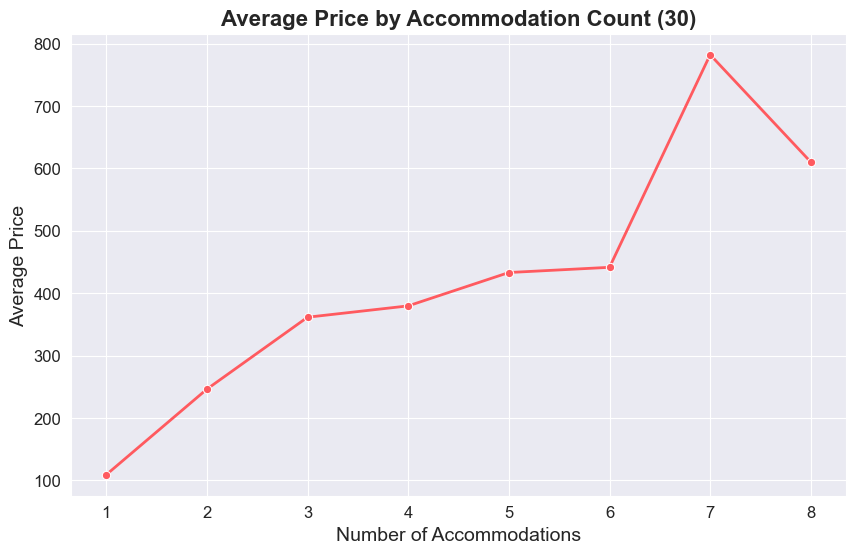

In [73]:
sns.set_style('darkgrid')

bnb_listing['accommodates'].unique()
accomodates_count = bnb_listing.groupby('accommodates')['price'].agg(['count', 'mean'])
accomodates_count = accomodates_count.rename(columns={'count': 'number_of_property', 'mean': 'avg_price'})
accomodates_count = accomodates_count.sort_values('avg_price', ascending=False)

#Filtering out property cateogry where number of properites are greater than 30
accomodates_count_30 = accomodates_count[accomodates_count['number_of_property'] > 30 ]


# Plot for accommodates_count
plt.figure(figsize=(10, 6)) 
sns.lineplot(x=accomodates_count.index, 
             y='avg_price', 
             data=accomodates_count, 
             marker='o', 
             color='#FF5A5F',
             linewidth=2, 
             markers=True)

# Customize the plot
plt.title('Average Price by Accommodation Count', fontsize=16, fontweight='bold')
plt.xlabel('Number of Accommodations', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

# Plot for accommodates_count_30
plt.figure(figsize=(10, 6))
sns.lineplot(x=accomodates_count_30.index, 
             y='avg_price', 
             data=accomodates_count_30, 
             marker='o', 
             color='#FF5A5F',
             linewidth=2, 
             markers=True)

# Customize the plot
plt.title('Average Price by Accommodation Count (30)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Accommodations', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [74]:
bnb_listing['bathrooms_text'].unique()

array(['1 private bath', 'Shared half-bath', '2 shared baths',
       '2.5 shared baths', '3 baths', '1 shared bath', '1 bath',
       '0 baths', '1.5 baths', '2 baths', nan, '4.5 baths',
       '3 shared baths', '4 baths', '8 baths', '0 shared baths',
       '1.5 shared baths', '5 shared baths', 'Half-bath',
       'Private half-bath', '2.5 baths', '6 baths', '4 shared baths',
       '7 shared baths', '8 shared baths', '6 shared baths', '5 baths',
       '3.5 baths', '4.5 shared baths', '8.5 shared baths', '8.5 baths',
       '10 baths', '10 shared baths', '21 shared baths',
       '3.5 shared baths', '16 shared baths', '16 baths', '13 baths',
       '13 shared baths', '5.5 baths'], dtype=object)

Predominance of Single-Bed Properties: The data indicates that the majority of properties listed are single-bedroom accommodations.

In [75]:
bnb_listing['beds'].unique()
bed_groups = bnb_listing.groupby('beds')['beds'].count().rename("Number of Properties")
print(bed_groups)

beds
1.0     2144
2.0      596
3.0      249
4.0      134
5.0       30
6.0       33
7.0        4
8.0       15
9.0        7
10.0      14
12.0       7
13.0       2
16.0      16
24.0       1
28.0       1
36.0       1
46.0       1
Name: Number of Properties, dtype: int64


Converting price to beans: Overall, the data suggests a significant concentration of properties in the 201-500 price range, followed by the 51-100 range, while higher-priced listings (501 and above) are less common.

In [76]:

bin_edges = [0, 50, 100, 150, 200, 500, 1000, float('inf')] 
bin_labels = ['0-50', '51-100', '101-150', '151-200', '201-500', '501-1000', '1000+']

# Create the 'price_category' column using pd.cut()
bnb_listing['price_category'] = pd.cut(bnb_listing['price'], bins=bin_edges, labels=bin_labels, right=False)

# Get unique price categories
unique_price_categories = bnb_listing['price_category'].unique()
price_category_counts = bnb_listing['price_category'].value_counts().sort_index()

# Print the unique price categories and their counts
print("Unique Price Categories:")
print(unique_price_categories)

print("\nCount of Properties in Each Price Category:")
print(price_category_counts)

Unique Price Categories:
['151-200', '51-100', '201-500', '101-150', '0-50', '501-1000', '1000+']
Categories (7, object): ['0-50' < '51-100' < '101-150' < '151-200' < '201-500' < '501-1000' < '1000+']

Count of Properties in Each Price Category:
price_category
0-50         347
51-100       713
101-150      424
151-200      353
201-500     1199
501-1000     209
1000+         84
Name: count, dtype: int64


In the pricing model, various price points are influenced primarily by location, given the critical role it plays in determining prices. Due to the absence of amenities data, the model will focus solely on location as the key factor affecting pricing.

accommodates                 1      2        3       4       5       6  \
neighbourhood_cleansed                                                   
Ang Mo Kio                52.0   94.0    216.0     NaN   650.0     NaN   
Bedok                     95.0  102.0    138.0   175.0   165.0  2110.0   
Bishan                   164.0   62.0    154.0   277.0     NaN  1250.0   
Bukit Batok               99.0  125.0     65.0   108.0    84.0   180.0   
Bukit Merah               72.0  223.0    282.0   320.0   684.0   470.0   
Bukit Panjang            185.0  117.0      NaN    70.0     NaN     NaN   
Bukit Timah               71.0  155.0     90.0    95.0     NaN   300.0   
Central Water Catchment    NaN  175.0    250.0   300.0     NaN   352.0   
Changi                     NaN  254.0      NaN   142.0     NaN     NaN   
Choa Chu Kang             62.0   74.0      NaN     NaN     NaN     NaN   
Clementi                 115.0  133.0    256.0   368.0   442.0   345.0   
Downtown Core            129.0  278.0 

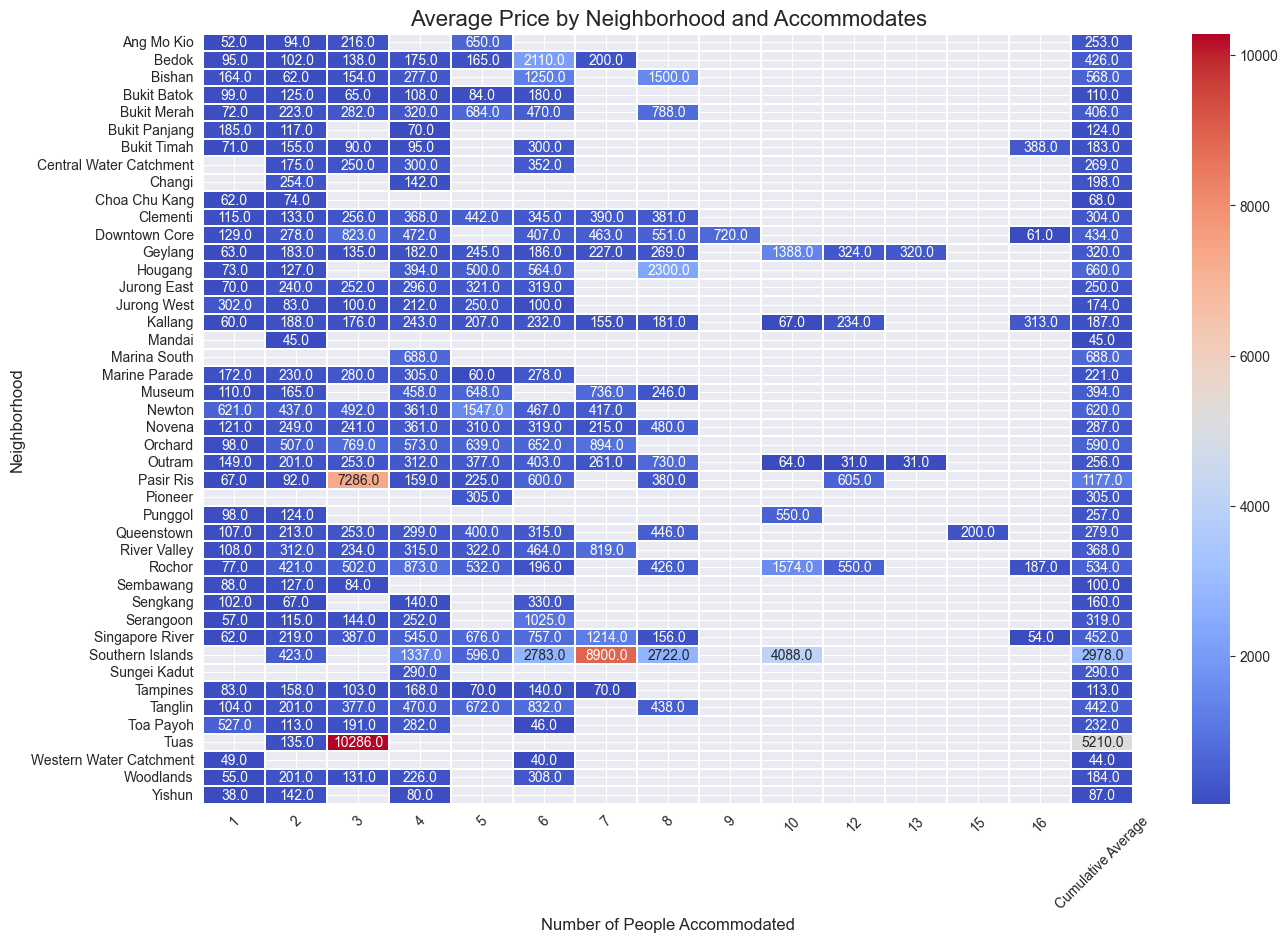

In [77]:
# Create the pivot table
pivot_table = bnb_listing.pivot_table(
    values='price', 
    index='neighbourhood_cleansed', 
    columns='accommodates', 
    aggfunc=lambda x: np.round(np.mean(x))
)

# Add the cumulative average as a new column
pivot_table['Cumulative Average'] = numeric_pivot_table.mean(axis=1).round(0).astype(int) 

# Print the pivot table (optional)
print(pivot_table)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, fmt="", cmap='coolwarm', linewidths=.2)  # Use fmt="" to handle mixed types
plt.title('Average Price by Neighborhood and Accommodates', fontsize=16)
plt.xlabel('Number of People Accommodated', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


For the modeling process, we will begin by using regional data, eventually narrowing down to specific locations if necessary. The Central region emerges as the most popular, featuring a diverse range of Airbnb listings and higher prices compared to other regions. Interestingly, while the Northeast region shows higher simple average prices, this does not accurately reflect its actual pricing situation.

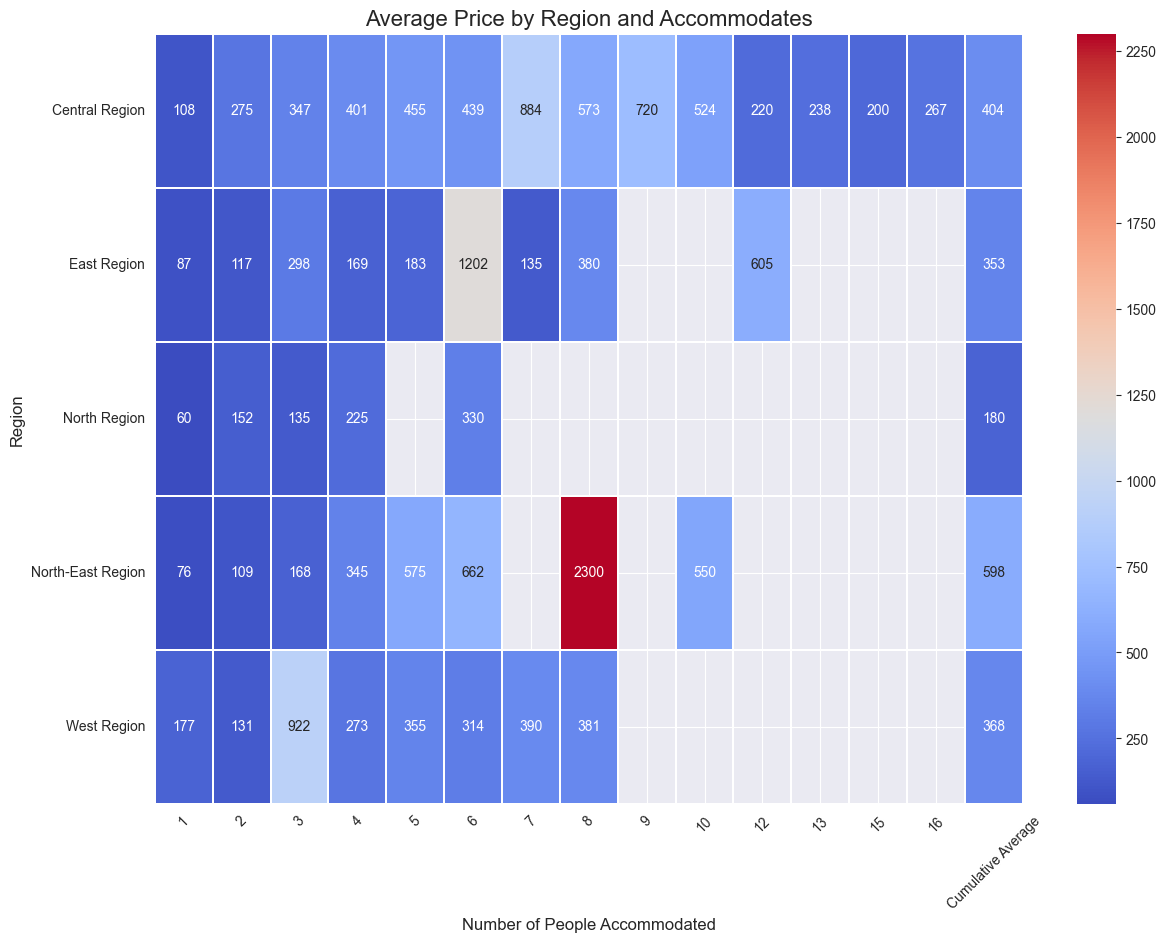

In [78]:
# Create the pivot table
pivot_table_2 = bnb_listing.pivot_table(
    values='price', 
    index='neighbourhood_group_cleansed', 
    columns='accommodates', 
    aggfunc=lambda x: np.round(np.mean(x))
)

# Add the cumulative average as a new column
pivot_table_2['Cumulative Average'] = pivot_table_2.mean(axis=1).round(0).astype(int)

# Create the heatmap with a rectangular figure size
plt.figure(figsize=(14, 10))  # Adjusted size for better ratio
sns.heatmap(pivot_table_2, annot=True, fmt=".0f", cmap='coolwarm', linewidths=.2)  # Use fmt=".0f" to show integers
plt.title('Average Price by Region and Accommodates', fontsize=16)
plt.xlabel('Number of People Accommodated', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Model Development
1. Separate out independent and dependent variables
2. Feature engineering 

In [79]:
x1_model = bnb_listing[['neighbourhood_cleansed','neighbourhood_group_cleansed','property_type',
                       'room_type','accommodates','bathrooms_text','beds','number_of_reviews','number_of_reviews_ltm',
                       'number_of_reviews_l30d','review_scores_rating','review_scores_accuracy',
                       'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                       'review_scores_value','reviews_per_month']]
y = bnb_listing['price']

In [80]:
x1_model['bathrooms_text'].unique()

baths = x1_model.groupby('bathrooms_text')['bathrooms_text'].agg('count')
print(baths)

bathrooms_text
0 baths                14
0 shared baths         28
1 bath               1157
1 private bath        590
1 shared bath         351
1.5 baths             125
1.5 shared baths       72
10 baths                4
10 shared baths         2
13 baths                2
13 shared baths         1
16 baths                2
16 shared baths         2
2 baths               447
2 shared baths        124
2.5 baths              18
2.5 shared baths       12
21 shared baths         2
3 baths                61
3 shared baths        148
3.5 baths               2
3.5 shared baths        2
4 baths                16
4 shared baths         34
4.5 baths               3
4.5 shared baths        1
5 baths                 3
5 shared baths         18
5.5 baths               1
6 baths                 7
6 shared baths          5
7 shared baths          3
8 baths                10
8 shared baths          3
8.5 baths               1
8.5 shared baths        4
Half-bath               6
Private half-bath      

From this we can do feature engineering, and identify the shared bath and number of bath, that we can impute the missing value or nan values.
- Half bath or full bath can be one columns
- Number of baths can  be another
- Private or shared can be another

Our assumbtion is where only bath is written , those are private full baths.

In [81]:
import re

# Convert column to string type
x1_model['bathrooms_text'] = x1_model['bathrooms_text'].astype(str)

# Iterate over the Series
for lab, row in x1_model['bathrooms_text'].items():
    # Use regular expression to extract number of bathrooms from string
    match = re.search(r'(\d+(\.\d+)?)', row)
    if match:
        # Assign the extracted number of bathrooms to a new column
        x1_model.loc[lab, 'num_bathrooms'] = float(match.group(1))
    else:
        x1_model.loc[lab, 'num_bathrooms'] = 1

    if 'shared' in row:
        x1_model.loc[lab, 'Shared_bath'] = 0
    else:
        x1_model.loc[lab, 'Shared_bath'] = 1

    if 'half' in row.lower():
        x1_model.loc[lab, 'Half_bath'] = 0
    elif 'Half' in row.lower():
        x1_model.loc[lab, 'Half_bath'] = 0
    else:
        x1_model.loc[lab, 'Half_bath'] = 1

/var/folders/yc/5rjgg5z50b78jfqjfqw0nb1w0000gn/T/ipykernel_25287/767389006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1_model['bathrooms_text'] = x1_model['bathrooms_text'].astype(str)
/var/folders/yc/5rjgg5z50b78jfqjfqw0nb1w0000gn/T/ipykernel_25287/767389006.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1_model.loc[lab, 'num_bathrooms'] = float(match.group(1))
/var/folders/yc/5rjgg5z50b78jfqjfqw0nb1w0000gn/T/ipykernel_25287/767389006.py:19: SettingWithCopyWarning: 
A value is trying to be

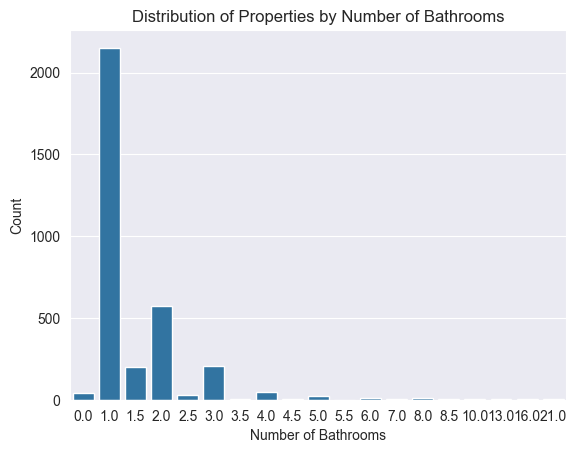

In [82]:
bath_details = x1_model.groupby('num_bathrooms')['num_bathrooms'].agg(numbers_bath='count').reset_index()

sns.barplot(x='num_bathrooms', y='numbers_bath', data=bath_details)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.title('Distribution of Properties by Number of Bathrooms')
plt.show()


In most of the properties only one bathroom is there

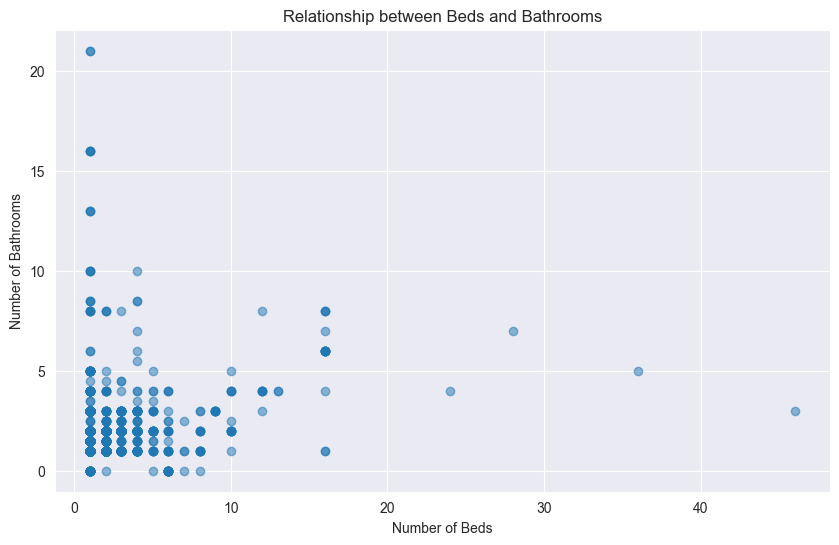

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(x1_model['beds'], x1_model['num_bathrooms'], alpha=0.5)
plt.xlabel('Number of Beds')
plt.ylabel('Number of Bathrooms')
plt.title('Relationship between Beds and Bathrooms')
plt.show()


In [85]:
# Replacing null beds with median values
for lab, row in x1_model.iterrows():
    if pd.isnull(row['beds']):
        x1_model.at[lab, 'beds'] = x1_model['beds'].mode()[0]


In [ ]:
# Assuming that average rating start with 3 and based on user experience it goes up and down. So we will update properties rating where no rating is given with 3
# Replacing null beds with median values
columns_to_fill = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                   'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                   'review_scores_value', 'reviews_per_month']

# Fill missing values with 3 for specified columns
x1_model[columns_to_fill] = x1_model[columns_to_fill].fillna(3)


In [44]:
x1_model_1500 = x1_model[x1_model['number_of_reviews'] != 0]

In [ ]:
x1_model_1500.isna().sum()

In [ ]:
x1_model_1500['property_type'].unique()

In [ ]:
x1_model['room_type'].unique()

In [ ]:
room_new_type = x1_model.groupby(['property_type', 'room_type'])['room_type'].agg(count='count')
print(room_new_type.sort_values(by='count', ascending=False))


In [56]:
# List of property types to check for
property_types = ['rental unit', 'serviced apartment', 'condo', 'hotel', 'home', 'boutique hotel',
                  'townhouse', 'aparthotel', 'hostel', 'bungalow', 'bed and breakfast', 'guesthouse', 'villa']

# Iterate over the rows in the 'property_type' column
for lab, row in x1_model_1500['property_type'].items():
    # Check if the property type exists in the row
    for prop_type in property_types:
        if prop_type.lower() in row.lower():
            x1_model_1500.loc[lab, prop_type] = 1
        else:
            x1_model_1500.loc[lab,prop_type] = 0
    # If property type not found, mark "other" column as 1



In [ ]:
sum_of_columns = x1_model_1500[property_types].sum(axis=1)
x1_model['other'] = 1 - sum_of_columns
x1_model_1500.loc[sum_of_columns == 1, 'other'] = 0

In [ ]:
x1_model_1500[['property_type','rental unit', 'serviced apartment', 'condo', 'hotel', 'home', 'boutique hotel',
                  'townhouse', 'aparthotel', 'hostel', 'bungalow', 'bed and breakfast', 'guesthouse', 'villa','other']].head()

Doing hot encodoing

In [ ]:
x1_model_1500['neighbourhood_cleansed'].unique()

In [53]:
x1_model_1500_dummy = pd.get_dummies(x1_model_1500[['neighbourhood_cleansed','neighbourhood_group_cleansed','room_type']]).astype(int)

In [ ]:
# Define the columns for x1_model and x1_dummy
x1_col1 = ['accommodates', 'beds', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
           'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month',
           'num_bathrooms', 'Shared_bath', 'Half_bath', 'rental unit', 'serviced apartment', 'condo', 'hotel', 'home',
           'boutique hotel', 'townhouse', 'aparthotel', 'hostel', 'bungalow', 'bed and breakfast', 'guesthouse',
           'villa', 'other']

# Select the columns from x1_dummy
x2_col2 = x1_model_1500_dummy.columns

# Concatenate x1_model and x1_dummy
x1_final_1500 = pd.concat([x1_model_1500[x1_col1], x1_model_1500_dummy[x2_col2]], axis=1)


In [ ]:
y_final_1500 = df['price'][x1_model['number_of_reviews'] != 0]

In [ ]:
y_final_1500 = bnb_listing['price'][x1_model['number_of_reviews'] != 0]
y_final_1500.head()

In [ ]:
x1_model_1500.head()